Static power flow examples

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from dem import *

matplotlib.rc("figure", figsize=(7,7))
matplotlib.rc("lines", linewidth=2)

# Basic examples

## Hello world

In [5]:
load = Load(p=100)
gen = Generator(p_max=1000, alpha=0.01, beta=100)
net = Net([load.terminals[0], gen.terminals[0]])

network = Group([load, gen], [net])
network.optimize()
network.print_results()

Terminal                  Power
--------                  -----
Load[0]                100.0000
Generator[0]          -100.0000

Net                       Price
---                       -----
Net                    102.0001


## Curtailable load

In [6]:
load = CurtailableLoad(p=1000, alpha=150)
gen = Generator(p_max=1000, alpha=1, beta=100)
net = Net([load.terminals[0], gen.terminals[0]])

network = Group([load, gen], [net])
network.optimize()
network.print_results()

Terminal                  Power
--------                  -----
CurtailableLoad[0]      25.0026
Generator[0]           -25.0026

Net                       Price
---                       -----
Net                    150.0000


## Two generators, transmission line

In [7]:
load = Load(p=100)
gen1 = Generator(p_max=1000, alpha=0.01, beta=100, name="Gen1")
gen2 = Generator(p_max=100, alpha=0.1, beta=0.1, name="Gen2")
line = TransmissionLine(p_max=50)

net1 = Net([load.terminals[0], gen1.terminals[0], line.terminals[0]])
net2 = Net([gen2.terminals[0], line.terminals[1]])

network = Group([load, gen1, gen2, line], [net1, net2])
network.optimize()
network.print_results()

Terminal                  Power
--------                  -----
Load[0]                100.0000
Gen1[0]                -50.0000
Gen2[0]                -50.0000
TransmissionLine[0]    -50.0000
TransmissionLine[1]     50.0000

Net                       Price
---                       -----
Net                    101.0001
Net                     10.1002


## Three buses

Figure 2.1 from Kraning, et al. without the battery.

![Three bus example](./three_bus.png)



In [8]:
load1 = Load(p=50, name="Load1")
load2 = Load(p=100, name="Load2")
gen1 = Generator(p_max=1000, alpha=0.01, beta=100, name="Gen1")
gen2 = Generator(p_max=100, alpha=0.1, beta=0.1, name="Gen2")
line1 = TransmissionLine(p_max=50)
line2 = TransmissionLine(p_max=10)
line3 = TransmissionLine(p_max=50)

net1 = Net([load1.terminals[0], gen1.terminals[0], line1.terminals[0], line2.terminals[0]])
net2 = Net([load2.terminals[0], line1.terminals[1], line3.terminals[0]])
net3 = Net([gen2.terminals[0], line2.terminals[1], line3.terminals[1]])

network = Group([load1, load2, gen1, gen2, line1, line2, line3], [net1, net2, net3])
network.optimize()
network.print_results()

Terminal                  Power
--------                  -----
Load1[0]                50.0000
Load2[0]               100.0000
Gen1[0]                -90.0000
Gen2[0]                -60.0000
TransmissionLine[0]     50.0000
TransmissionLine[1]    -50.0000
TransmissionLine[0]    -10.0000
TransmissionLine[1]     10.0000
TransmissionLine[0]    -50.0000
TransmissionLine[1]     50.0000

Net                       Price
---                       -----
Net                    101.8008
Net                    196.1916
Net                     12.0975


# Grouping devices

We can wrap up several devices and nets into a single device

In [2]:
solar = Generator(p_max=10, alpha=0, beta=0, name="Solar")
load = Load(p=13)
line = TransmissionLine(p_max=25)
net = Net([load.terminals[0], solar.terminals[0], line.terminals[0]])
home = Group([solar, load, line], [net], [line.terminals[1]], name="Home")

grid = Generator(p_max=1e6, alpha=0.05, beta=100, name="Grid")
meter = Net([line.terminals[1], grid.terminals[0]], name="Meter")

network = Group([home, grid], [meter])
network.optimize()
network.print_results()

Terminal                  Power
--------                  -----
Home[0]                  3.0000
Grid[0]                 -3.0000

Net                       Price
---                       -----
Meter                  100.3000


# Varying parameters

We can modify a single parameter and reoptimize, which is useful for sweeping over a parameter range.

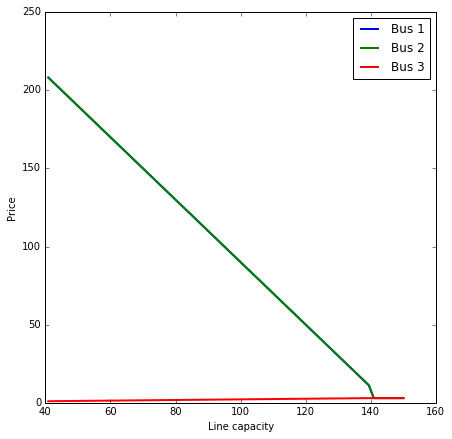

In [4]:
load1 = Load(p=50, name="Load1")
load2 = Load(p=100, name="Load2")
gen1 = Generator(p_max=100, alpha=1, beta=10, name="Gen1")
gen2 = Generator(p_max=1000, alpha=0.01, beta=0, name="Gen2")
line1 = TransmissionLine(p_max=100)
line2 = TransmissionLine(p_max=10)
line3 = TransmissionLine()

net1 = Net([load1.terminals[0], gen1.terminals[0], line1.terminals[0], line2.terminals[0]])
net2 = Net([load2.terminals[0], line1.terminals[1], line3.terminals[0]])
net3 = Net([gen2.terminals[0], line2.terminals[1], line3.terminals[1]])
network = Group([load1, load2, gen1, gen2, line1, line2, line3], [net1, net2, net3])

xs = np.linspace(0, 150, 100)
prices = np.empty((len(xs), 3))
for i, x in enumerate(xs):
    line3.p_max = x
    network.optimize()
    prices[i,:] = [net.price for net in network.nets]
    
plt.plot(xs, prices)
plt.xlabel("Line capacity")
plt.ylabel("Price")
plt.legend(["Bus 1", "Bus 2", "Bus 3"])

# IEEE 14 bus power flow test cases

From http://www.ee.washington.edu/research/pstca/pf14/pg_tca14bus.htm:

> The IEEE 14 Bus Test Case represents a portion of the American Electric Power System (in the Midwestern US) as of February, 1962. A much-Xeroxed paper version of the data was kindly provided by Iraj Dabbagchi of AEP and entered in IEEE Common Data Format by Rich Christie at the University of Washington in August 1993. 

In [ ]:
# TODO(mwytock): write parsing code
devices, nets = read_ieee_cdf(open("ieee14cdf.txt"))
optimize(devices, nets)
print_results(devices, nets)